In [1]:
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
from scipy.ndimage import gaussian_filter
import xarray as xr

In [2]:
# Open NCEP GFS dataset; change name accordingly to yours
ds = xr.open_dataset('US_MESOSCALE/081416_0600H.f00.nc4')
ds

<xarray.Dataset>
Dimensions:                                                          (
                                                                      height_above_ground_layer: 1,
                                                                      bounds_dim: 2,
                                                                      potential_vorticity_surface: 2,
                                                                      pressure_difference_layer2: 2,
                                                                      latitude: 29,
                                                                      isobaric3: 31,
                                                                      height_above_ground1: 3,
                                                                      time: 1,
                                                                      height_above_ground_layer1: 1,
                                                                      longitude: 33)
Coordinates:
  * height_above_ground_layer                                        (height_above_ground_layer) float64 ...
    reftime                                                          datetime64[ns] ...
  * potential_vorticity_surface                                      (potential_vorticity_surface) float64 ...
  * pressure_difference_layer2                                       (pressure_difference_layer2) float64 ...
  * latitude                                                         (latitude) float32 ...
  * isobaric3                                                        (isobaric3) float64 ...
  * height_above_ground1                                             (height_above_ground1) float64 ...
  * time                                                             (time) datetime64[ns] ...
  * height_above_ground_layer1                                       (height_above_ground_layer1) float64 ...
  * longitude                                                        (longitude) float32 ...
Dimensions without coordinates: bounds_dim
Data variables: (12/23)
    height_above_ground_layer_bounds                                 (height_above_ground_layer, bounds_dim) float64 ...
    pressure_difference_layer2_bounds                                (pressure_difference_layer2, bounds_dim) float64 ...
    height_above_ground_layer1_bounds                                (height_above_ground_layer1, bounds_dim) float64 ...
    Convective_available_potential_energy_pressure_difference_layer  (time, pressure_difference_layer2, latitude, longitude) float32 ...
    U-Component_Storm_Motion_height_above_ground_layer               (time, height_above_ground_layer1, latitude, longitude) float32 ...
    Convective_inhibition_surface                                    (time, latitude, longitude) float32 ...
    ...                                                               ...
    Storm_relative_helicity_height_above_ground_layer                (time, height_above_ground_layer, latitude, longitude) float32 ...
    Best_4_layer_Lifted_Index_surface                                (time, latitude, longitude) float32 ...
    V-Component_Storm_Motion_height_above_ground_layer               (time, height_above_ground_layer1, latitude, longitude) float32 ...
    Convective_available_potential_energy_surface                    (time, latitude, longitude) float32 ...
    Wind_speed_gust_surface                                          (time, latitude, longitude) float32 ...
    LatLon_721X1440-0p13S-180p00E                                    int32 ...
Attributes: (12/13)
    Originating_or_generating_Center:                                        ...
    Originating_or_generating_Subcenter:                                     ...
    GRIB_table_version:                                                      ...
    Type_of_generating_process:                                              ...
    Analysis_or_forecast_generating_process_identifier_defined_by

In [3]:
# Grab lat/lon values (NAM will be 2D)
lats = ds['latitude']
lons = ds['longitude']

# Select and grab data
rh = ds['Relative_humidity_isobaric']
temp = ds['Temperature_isobaric']
uwnd = ds['u-component_of_wind_isobaric']
vwnd = ds['v-component_of_wind_isobaric']
usurf = ds['u-component_of_wind_height_above_ground']
vsurf = ds['v-component_of_wind_height_above_ground']

# Query in surface wind components. 
uwnd_surf = gaussian_filter(usurf.sel(height_above_ground1=10).data[0], sigma=1) * units('m/s')
vwnd_surf = gaussian_filter(vsurf.sel(height_above_ground1=10).data[0], sigma=1) * units('m/s')

# Select wind components at 850 and 500 hPa. Calculate each isobarics' wind speeds 
# and direction
uwnd_850 = gaussian_filter(uwnd.sel(isobaric3=85000).data[0], sigma=3.0) * units('m/s')
uwnd_850 = uwnd_850.to(units.knots)
vwnd_850 = gaussian_filter(vwnd.sel(isobaric3=85000).data[0], sigma=3.0) * units('m/s')
vwnd_850 = vwnd_850.to(units.knots)

uwnd_500 = gaussian_filter(uwnd.sel(isobaric3=50000).data[0], sigma=3.0) * units('m/s')
uwnd_500 = uwnd_500.to(units.knots)
vwnd_500 = gaussian_filter(vwnd.sel(isobaric3=50000).data[0], sigma=3.0) * units('m/s')
vwnd_500 = vwnd_500.to(units.knots)

v_850 = mpcalc.wind_speed(uwnd_850, vwnd_850)
v_500 = mpcalc.wind_speed(uwnd_500, vwnd_500)
dir_850 = mpcalc.wind_direction(uwnd_850, vwnd_850)
dir_500 = mpcalc.wind_direction(uwnd_500, vwnd_500)

# Select parameters to compute for Dewpoint temperatures at 850 hPa and 
# Totals Total Index and SWEAT Index eventually
rh_850 = gaussian_filter(rh.sel(isobaric3=85000).data[0], sigma=3.0) * units.percent
temp_850 = gaussian_filter(temp.sel(isobaric3=85000).data[0], sigma=3.0) * units.kelvin
temp_850c = temp_850.to('degC')
temp_500 = gaussian_filter(temp.sel(isobaric3=50000).data[0], sigma=3.0) * units.kelvin
temp_500c = temp_500.to('degC')

td_850 = mpcalc.dewpoint_from_relative_humidity(temp_850c, rh_850)

vt = temp_850c - temp_500c
ct = td_850 - temp_500c

tt = ct + vt # However, our Totals Total Index is below '49' so the whole term is essentially 0

# Calculate for SWEAT Index
term_1 = 12 * td_850
term_3 = v_850 + v_500
term_31 = 2 * term_3
term_4 = dir_500 - dir_850
term_41 = np.sin(term_4)
term_42 = term_41 + 0.2
term_43 = 125 * term_42

sweat_ix = term_1.m + 0 + term_31.m + term_43.m # Take the magnitudes

# Create a clean datetime object for plotting
vtime = datetime.strptime(str(ds.time.data[0].astype('datetime64[ms]')),
                          '%Y-%m-%dT%H:%M:%S.%f')

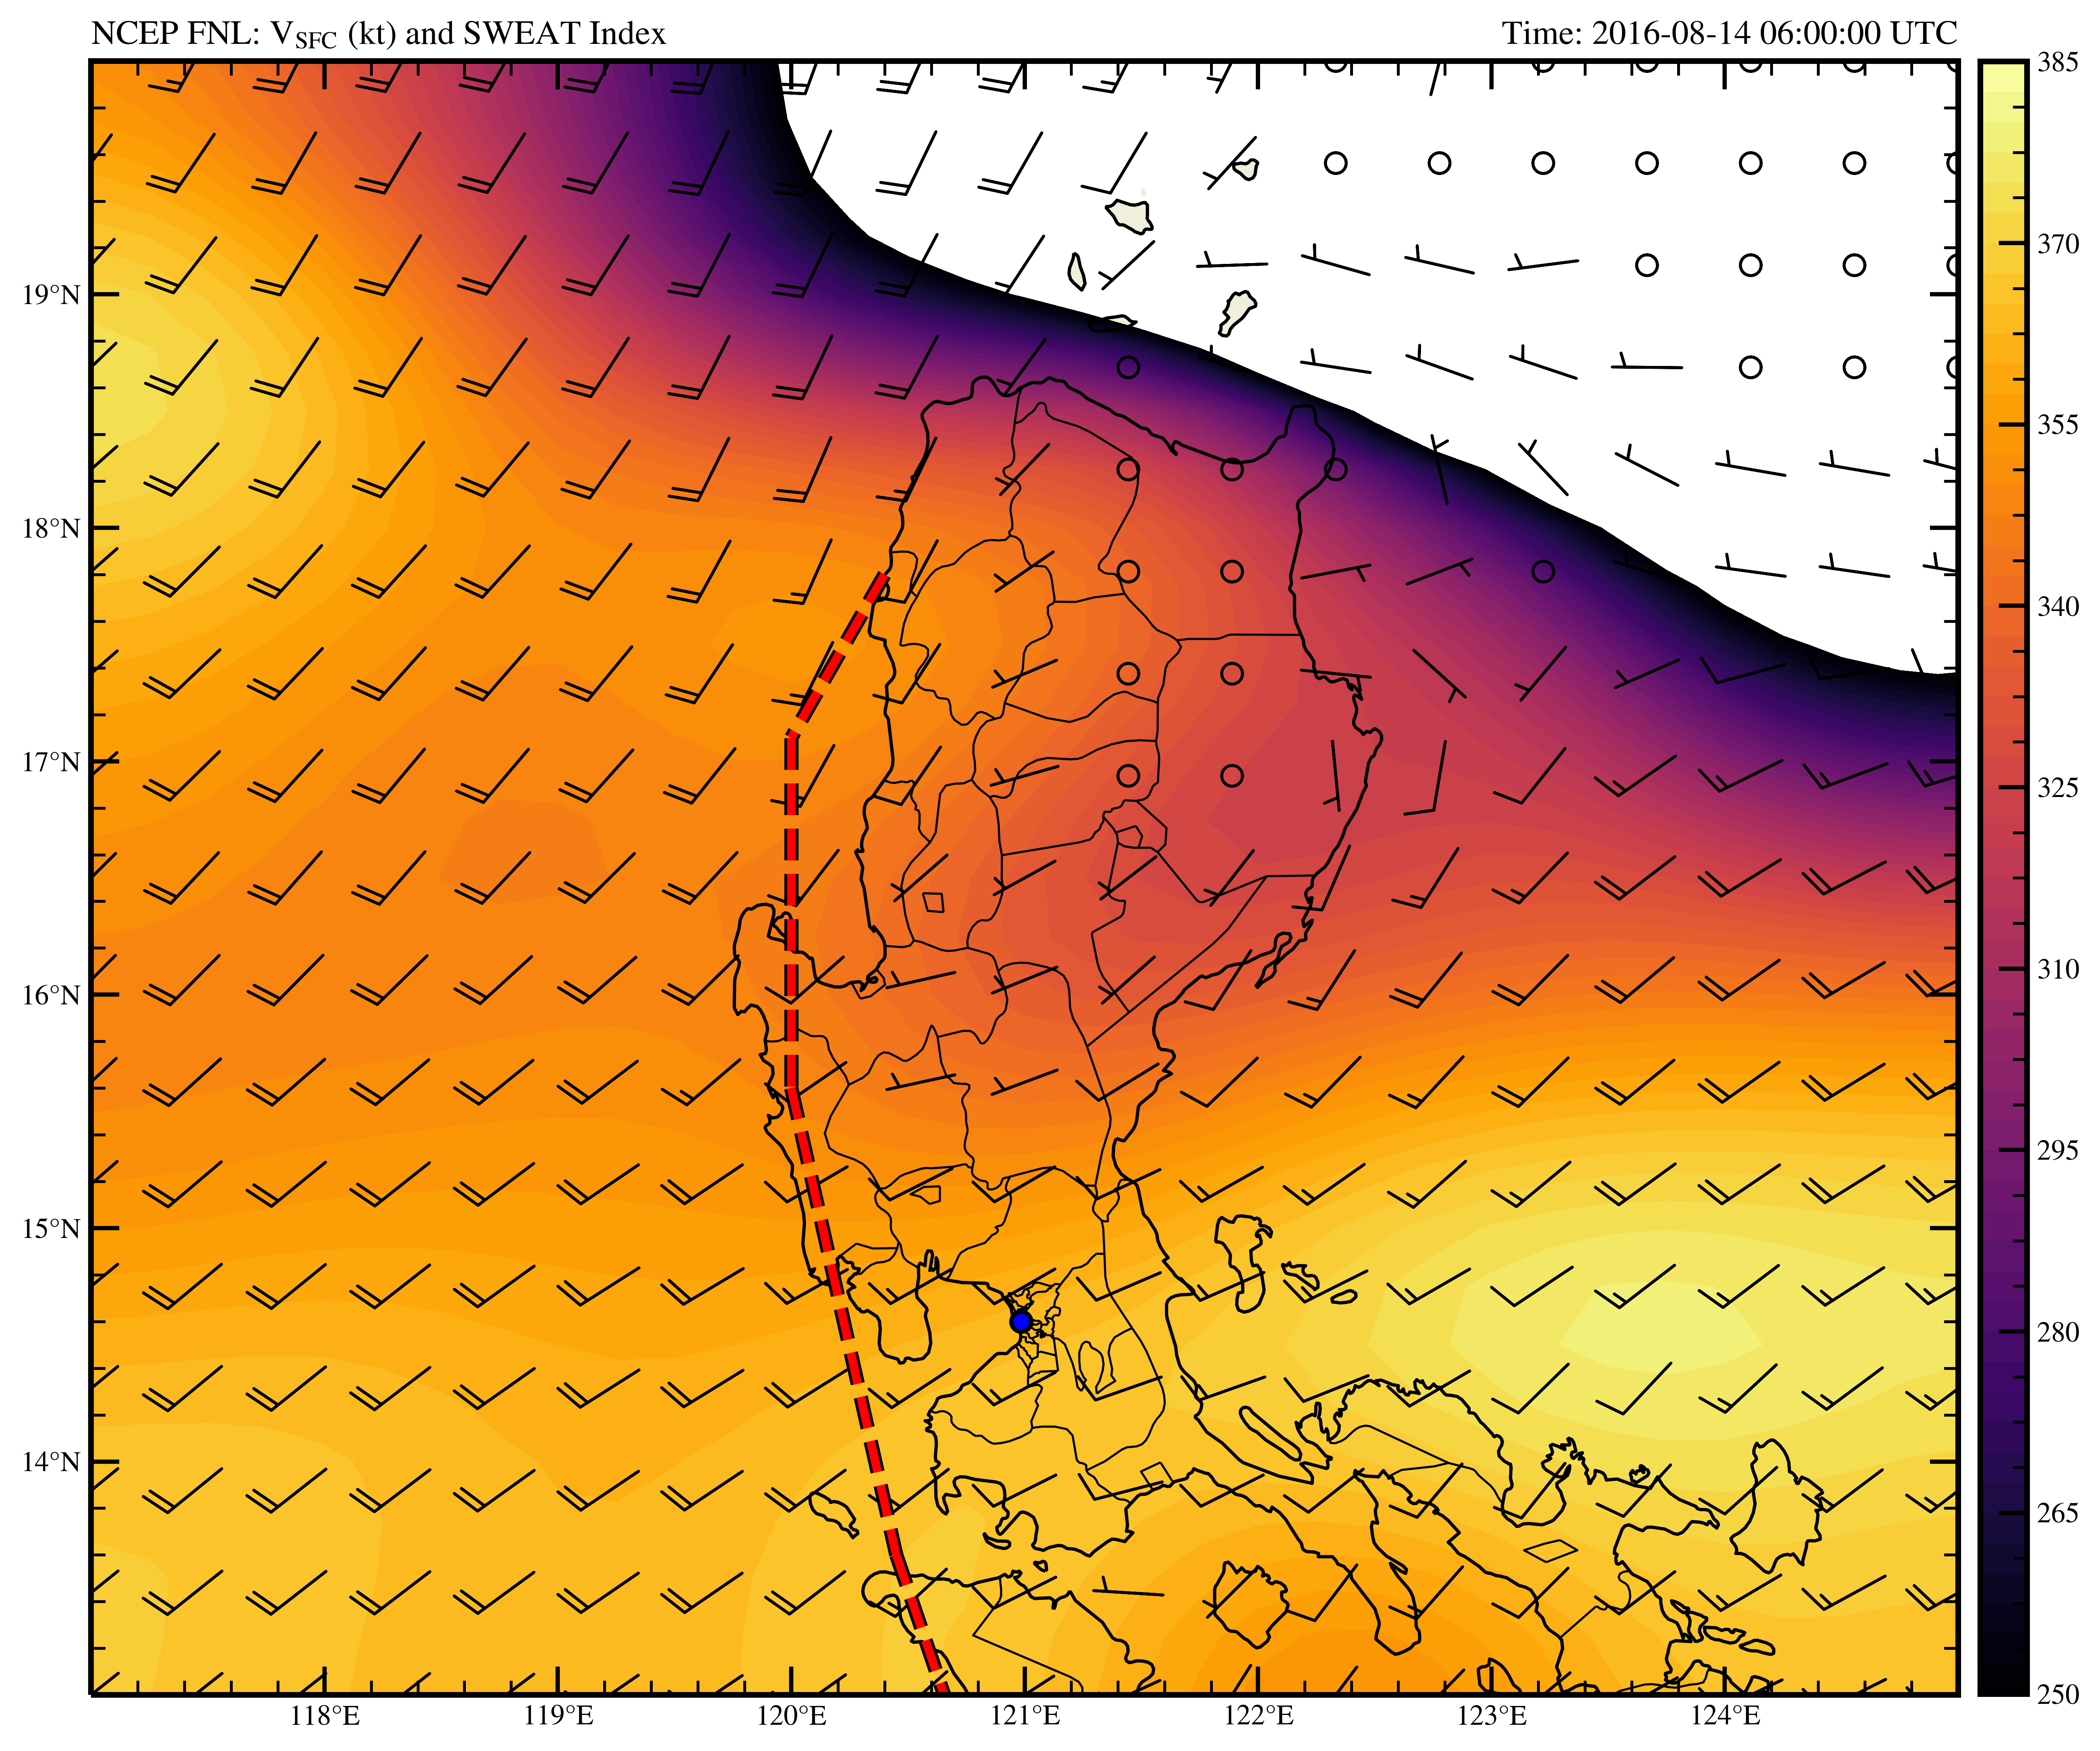

In [5]:
# Set up the projection that will be used for plotting
mapcrs = ccrs.PlateCarree()

# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

# Start the figure and create plot axes with proper projection
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=datacrs)
ax.set_extent([117, 125, 13, 20], ccrs.PlateCarree())

# Add geopolitical boundaries for map reference
states_provinces = cfeature.NaturalEarthFeature(category='cultural', 
                                                name='admin_1_states_provinces_lines', 
                                                scale='10m', facecolor='none', linewidth=0.75)
ax.add_feature(states_provinces, edgecolor='k')
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=1.15)
ax.add_feature(cfeature.STATES.with_scale('50m'))
ax.add_feature(cfeature.LAND)

# Add SWEAT contour filled. Minimum of 250; Severe storms may still be 
# possible for SWEAT values of 250-300 if strong lifting is present. 
sw_r = np.arange(250, 387.5, 2.5)
srh = ax.contourf(lons, lats, sweat_ix, sw_r, cmap='inferno', transform=datacrs)
cbar = plt.colorbar(srh, orientation='vertical', pad=0.01, aspect=35, shrink=0.664)
cbar.ax.minorticks_on()
cbar.ax.tick_params(which='major', length=10, width=1.5, top=True, right=True, direction='in')
cbar.ax.tick_params(which='minor', length=5, width=1, top=True, right=True, direction='in')

# Add Surface Wind Barbs
ax.barbs(lons, lats, uwnd_surf.to('kt').m, vwnd_surf.to('kt').m, pivot='middle', 
         color='black', regrid_shape=17, transform=datacrs)

# Create a/the line(s) that highlights the surface trough
outline=pe.withStroke(linewidth=5, foreground='k')

point1 = dict(lon=120.40, lat=17.80)
point2 = dict(lon=120.00, lat=17.10)
lon_p = [point1['lon'], point2['lon']]
lat_p = [point1['lat'], point2['lat']]
ax.plot(lon_p, lat_p, color='red', lw=3, ls='--', 
        path_effects=[outline, pe.Normal()], transform=ccrs.Geodetic())

point3 = dict(lon=120.00, lat=17.10)
point4 = dict(lon=120.00, lat=15.60)
lon_p1 = [point3['lon'], point4['lon']]
lat_p1 = [point3['lat'], point4['lat']]
ax.plot(lon_p1, lat_p1, color='red', lw=3, ls='--', 
        path_effects=[outline, pe.Normal()], transform=ccrs.Geodetic())

point5 = dict(lon=120.00, lat=15.60)
point6 = dict(lon=120.45, lat=13.60)
lon_p2 = [point5['lon'], point6['lon']]
lat_p2 = [point5['lat'], point6['lat']]
ax.plot(lon_p2, lat_p2, color='red', lw=3, ls='--', 
        path_effects=[outline, pe.Normal()], transform=ccrs.Geodetic())

point7 = dict(lon=120.45, lat=13.60)
point8 = dict(lon=121.10, lat=11.70)
lon_p3 = [point7['lon'], point8['lon']]
lat_p3 = [point7['lat'], point8['lat']]
ax.plot(lon_p3, lat_p3, color='red', lw=3, ls='--', 
        path_effects=[outline, pe.Normal()], transform=ccrs.Geodetic())

# Make some nice titles for the plot (one right, one left)
ax.set_title('NCEP FNL: V$_{SFC}$ (kt) and SWEAT Index', loc='left')
ax.set_title('Time: {} UTC'.format(vtime), loc='right')

# Add marker of Manila, NCR via its lats and lons
manila_lon, manila_lat = 120.9842, 14.5995
ax.plot(manila_lon, manila_lat, color='blue', markersize=7, 
        markeredgewidth=1.5, markeredgecolor='k', marker='o', transform=datacrs)

# Set X and Y-ticks for Latitude and Longitude Coordinates
ax.set_yticks(lats, 5, crs=ccrs.PlateCarree())
ax.set_xticks(lons, 5, crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
long_formatter = cticker.LongitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)
ax.xaxis.set_major_formatter(long_formatter)
ax.set_xticks(ax.get_xticks()[1:8]) #Hide end points of longitude tickmarks
ax.set_yticks(ax.get_yticks()[1:7]) #Hide end points of latitude tickmarks
ax.minorticks_on() 
ax.tick_params(which='major', length=10, width=1.5, top=True, right=True, direction='in')
ax.tick_params(which='minor', length=5, width=1, top=True, right=True, direction='in')

# Adjust image and show
plt.subplots_adjust(bottom=0, top=1)
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['figure.dpi'] = 500
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams["mathtext.default"] = 'regular'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.savefig('Vsurf and SWEAT.jpg', bbox_inches="tight")
plt.show()